In [ ]:
#the below was adapted from this sentiment analysis tutorial:
# a significant portion of this code is over my head, especially code surrounding classes. 

#(https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=fMSr7C-F_sey)
#(https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
#videos to go along with the notebooks:
#https://www.youtube.com/watch?v=Osj0Z6rwJB4
#https://www.youtube.com/watch?time_continue=737&v=8N-nM3QW7O0&feature=emb_logo

# Setup:

In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.7.7
IPython 7.13.0

numpy 1.18.5
pandas 1.0.4
torch 1.5.0
transformers 2.11.0


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import urllib.request
import urllib.parse
import json
import pandas as pd
from pandas import json_normalize
from time import sleep

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
#load training datasets

#1)
#imdb from http://ai.stanford.edu/~amaas/data/sentiment/
#"We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing."

#2)
#google play reviews
df = pd.read_csv("reviews.csv")
df.head()


,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [4]:
df.shape

(15746, 11)

In [5]:
#We have about 16k examples, Let's check for missing values:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [7]:
#No missing values, noice. 

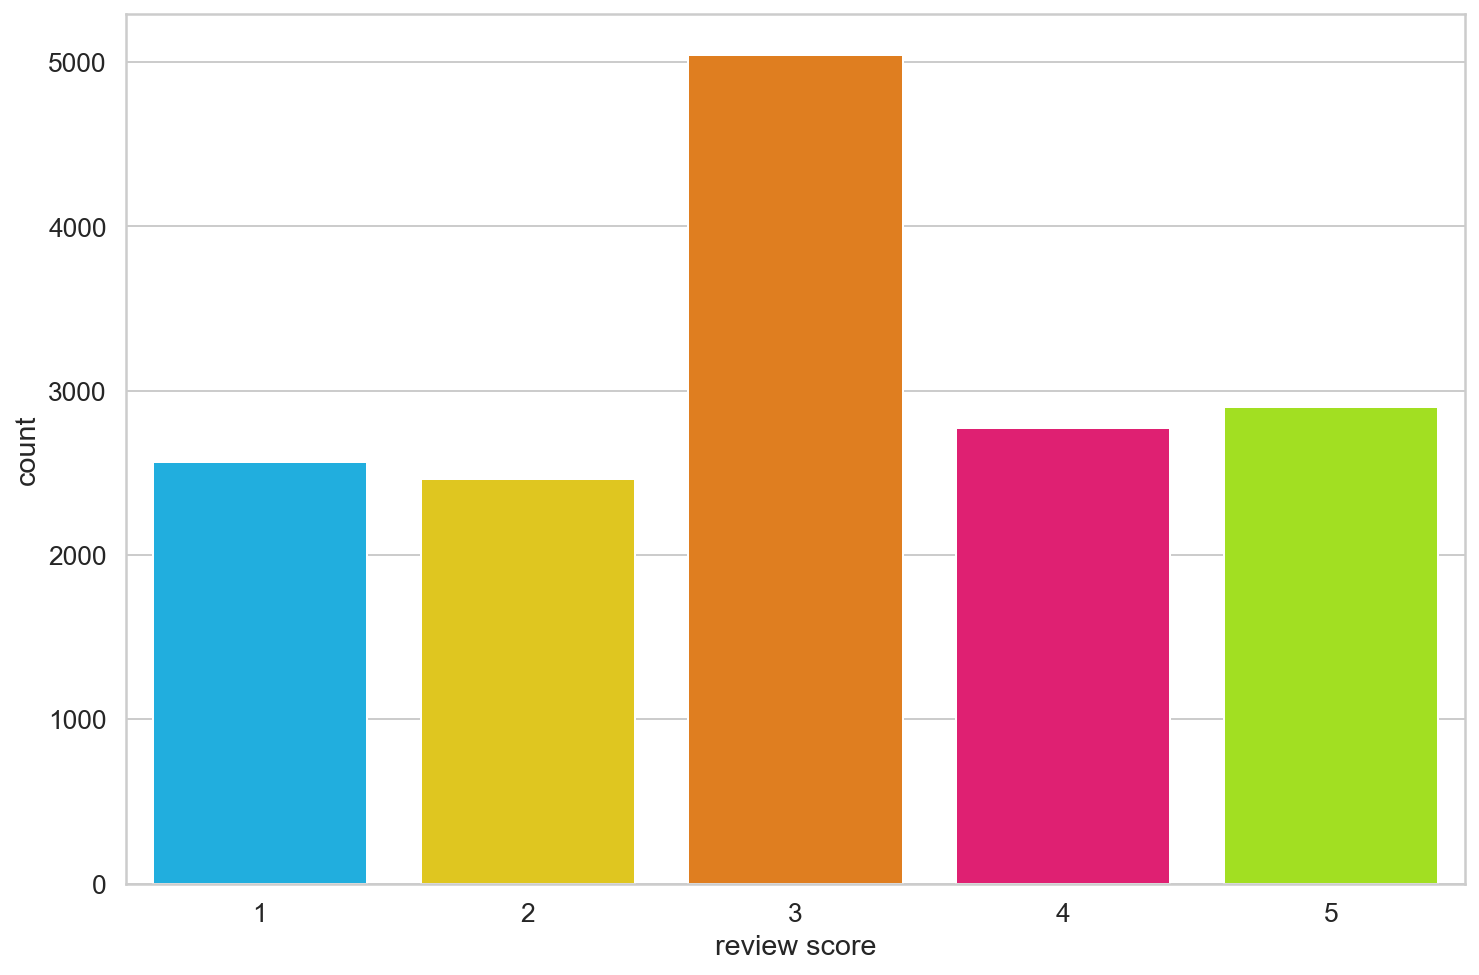

In [8]:
#Let's look at our classes
sns.countplot(df.score)
plt.xlabel('review score');

In [9]:
#Imbalce is ok, because we're dividing between negative(1,2) neutral(3) and positive (4,5)

def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

#apply above function to dataset
df['sentiment'] = df.score.apply(to_sentiment)


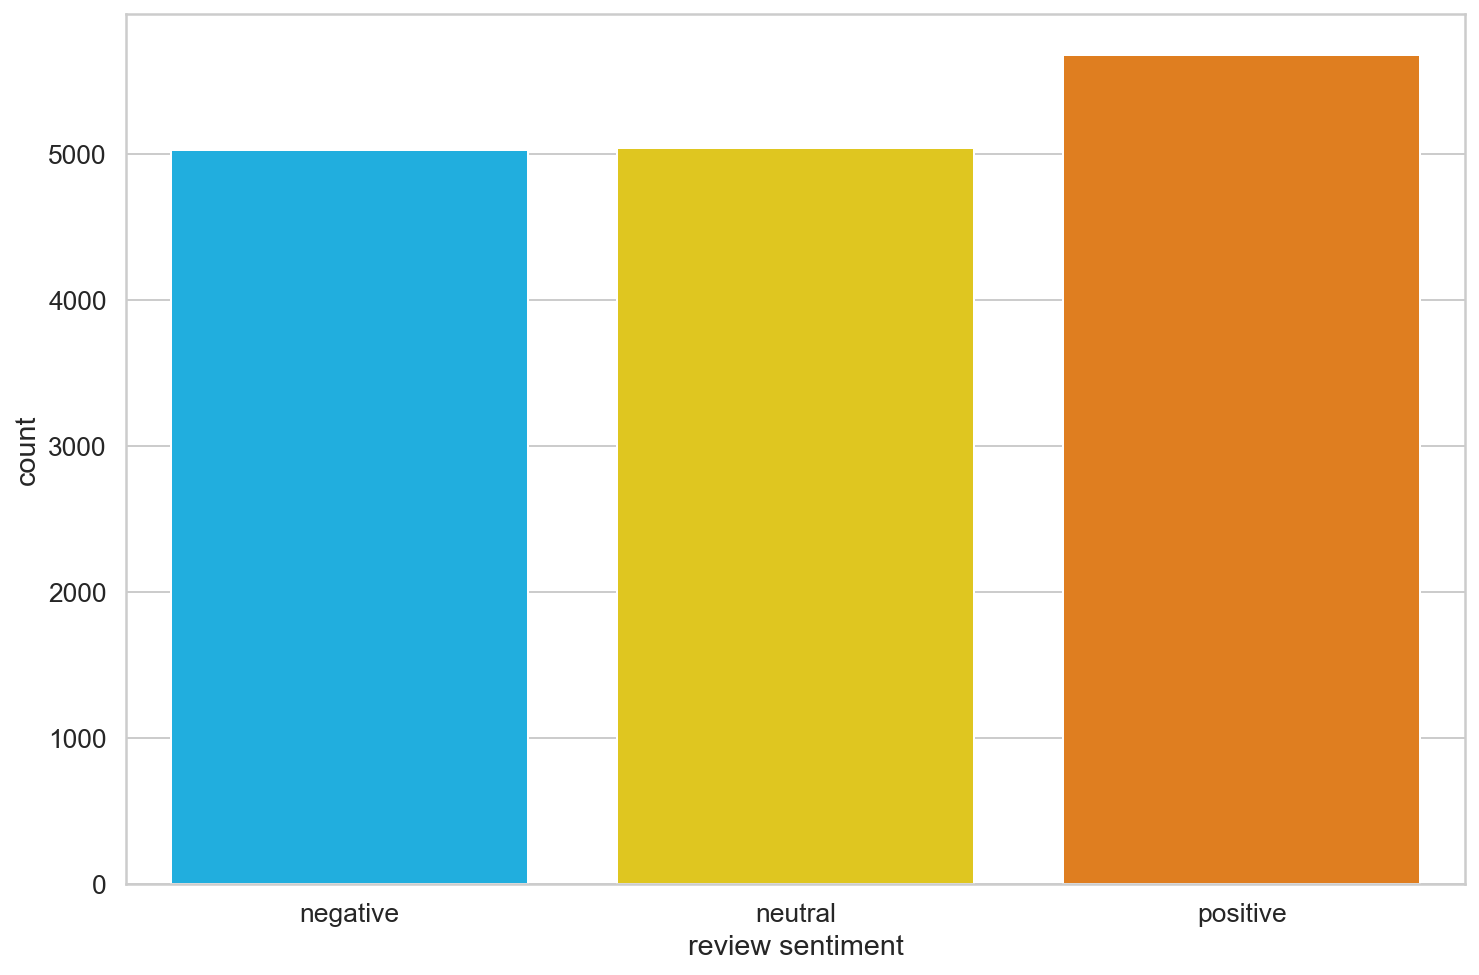

In [10]:
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [11]:
#The balance is (mostly) restored. 

# Data Preprocessing

1) Add special tokens to separate sentences and do classification

2) Pass sequences of constant length (introduce padding)

3) Create array of 0s (pad token) and 1s (real token) called 'attention mask'

In [12]:
#there are two model types to choose from, case and uncased. 
#We're using 'cased', as "BAD" might convey more sentiment than "bad".

#identify model
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [13]:
#load pre-trained BertTokenizer
#https://huggingface.co/transformers/model_doc/bert.html#berttokenizer

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

#if you get an error, execute 'conda install -c conda-forge ipywidgets' in your env:
#https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [14]:
#sample text 
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

#sample tokenizer
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [15]:
#alright, that's cool, now let's look at the different kinds of tokens..

In [16]:
#Special Tokens:

#[SEP] - marker for ending of a sentence
print(tokenizer.sep_token, tokenizer.sep_token_id)

#[CLS] - marker for start of a sentence, flags sentence for bert-classification
print(tokenizer.cls_token, tokenizer.cls_token_id)

#[PAD] - marker for everything in between
print(tokenizer.pad_token, tokenizer.pad_token_id)

#[UNK] - marker for unknown items
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [17]:
#now let's tokenize our sample_txt with an encoding method, encore_plut()
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

#inspect keys
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [18]:
#token ids are now stored in a Tensor, padded to a length of 32
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]


32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [19]:
#attention mask is stored at the same length
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

# Now let's process our training dataset.

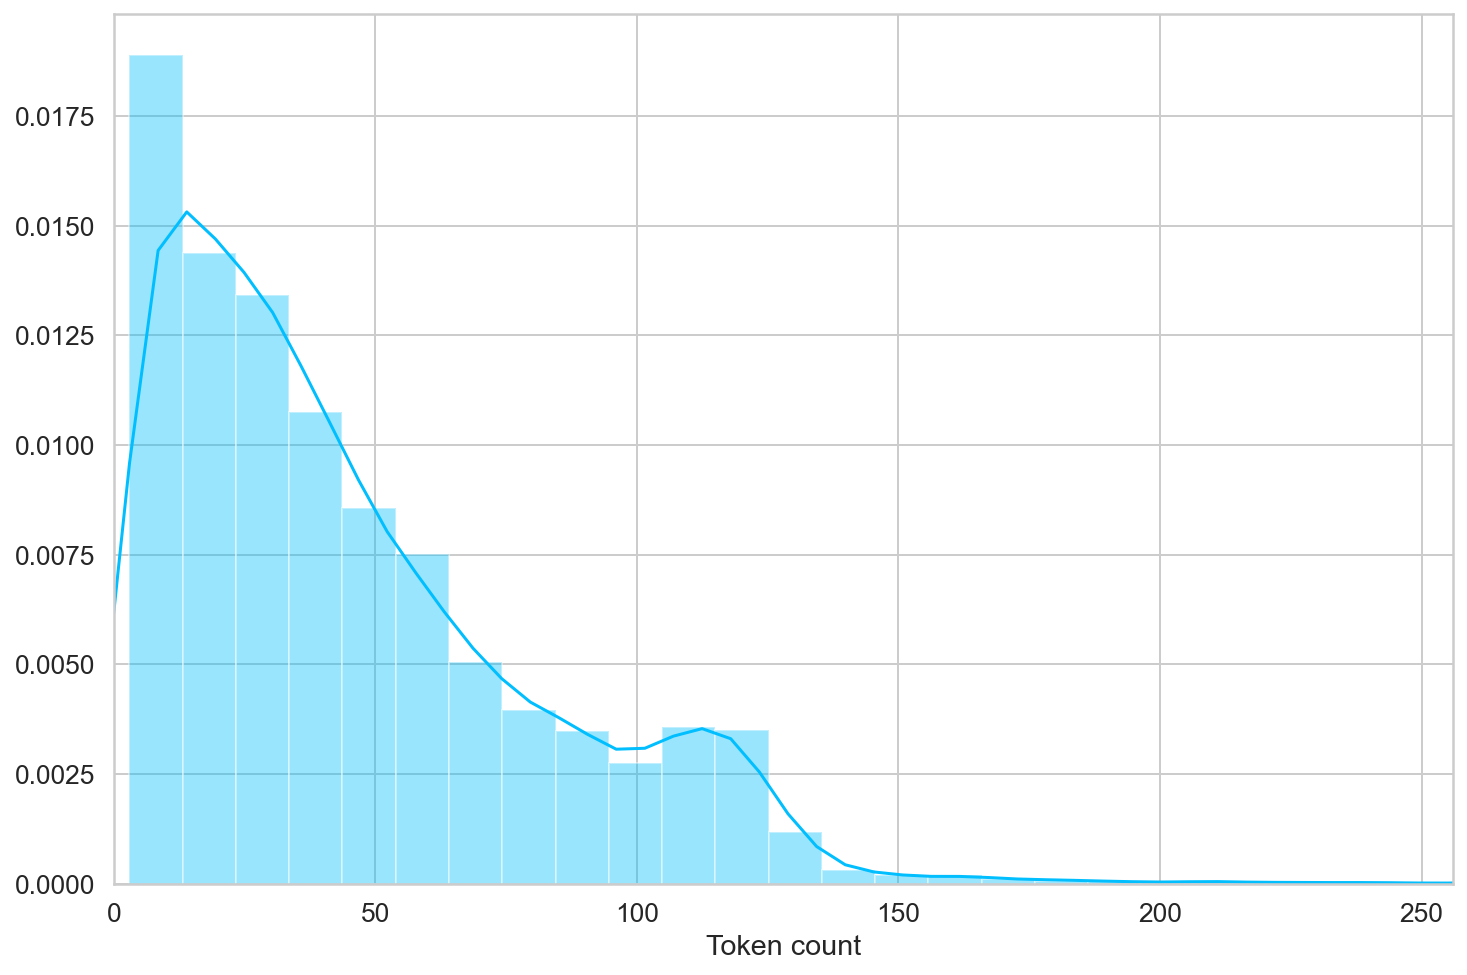

In [20]:
#BERT works with fixed-length sequences. Let's inspect the length of each review from our training dataset
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
    
#let's plot the distribution to get a sense of what we're working with
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [21]:
#99% of the revews appear to have a token length less than 125, but to be safe let's go with 160.
MAX_LEN = 160

In [22]:
#let's format our dataset to PyTorch dataset.

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [23]:
#test-train-split training data
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [24]:
#inspect
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [31]:
#data loader, that's required in the tutorial. I see that it's converting things to numpy arrays, 
#but aside from that, that's all I understand (sadly)

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0 #when running pytorch in windows, not linux, you need to set this to zero or it crashes.  
  )               #https://github.com/pytorch/pytorch/issues/2341

In [32]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [33]:
#let's look at an example batch from out trining data loader:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [34]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Sentiment Classification with BERT and Hugging Face

In [35]:
# load model:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [37]:
#test model on our 'sample_text'
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

#output
last_hidden_state.shape

torch.Size([1, 32, 768])

In [38]:
#the 768 is the number of hidden units in the feedfoward-network
bert_model.config.hidden_size


768

In [39]:
#we use this knowledge to make a classifier that uses the BERT mdoel:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [40]:
#let's make an instace if the the above class and move it to our GPU
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [41]:
#let's move the example batch of our training data to the GPU:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [42]:
#get predicted probabilities from out trained model, then apploy softmax funciton to the outputs
# I have no idea what the softmax function does

F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5204, 0.1950, 0.2846],
        [0.5059, 0.2481, 0.2460],
        [0.6054, 0.1635, 0.2311],
        [0.3443, 0.2551, 0.4006],
        [0.5166, 0.2660, 0.2174],
        [0.5045, 0.1006, 0.3949],
        [0.4839, 0.1864, 0.3297],
        [0.6316, 0.1907, 0.1777],
        [0.5375, 0.2170, 0.2455],
        [0.5496, 0.1816, 0.2687],
        [0.6060, 0.2544, 0.1396],
        [0.6902, 0.1274, 0.1824],
        [0.5324, 0.3334, 0.1341],
        [0.5111, 0.2635, 0.2254],
        [0.3591, 0.3027, 0.3381],
        [0.5413, 0.2114, 0.2474]], device='cuda:0', grad_fn=<SoftmaxBackward>)

# Training

In [43]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [44]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [45]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [46]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7397617504639765 accuracy 0.6668548444005363
Val   loss 0.6176942241191864 accuracy 0.7573062261753495

Epoch 2/10
----------
Train loss 0.42548416616315227 accuracy 0.8425658034013126
Val   loss 0.5607726401090622 accuracy 0.8398983481575604

Epoch 3/10
----------
Train loss 0.24205646354023946 accuracy 0.9197657187213323
Val   loss 0.663672836124897 accuracy 0.8538754764930114

Epoch 4/10
----------
Train loss 0.16021577812075347 accuracy 0.9527909110154541
Val   loss 0.7859401834011078 accuracy 0.8640406607369759

Epoch 5/10
----------
Train loss 0.11640075047166165 accuracy 0.9674687742572861
Val   loss 0.909357528090477 accuracy 0.8589580686149937

Epoch 6/10
----------
Train loss 0.0837283140767374 accuracy 0.9769247053842355
Val   loss 0.810398271381855 accuracy 0.8703939008894537

Epoch 7/10
----------
Train loss 0.0673052700232235 accuracy 0.9805236045444923
Val   loss 0.9062847448140383 accuracy 0.8678526048284626

Epoch 8/10
----------
Trai

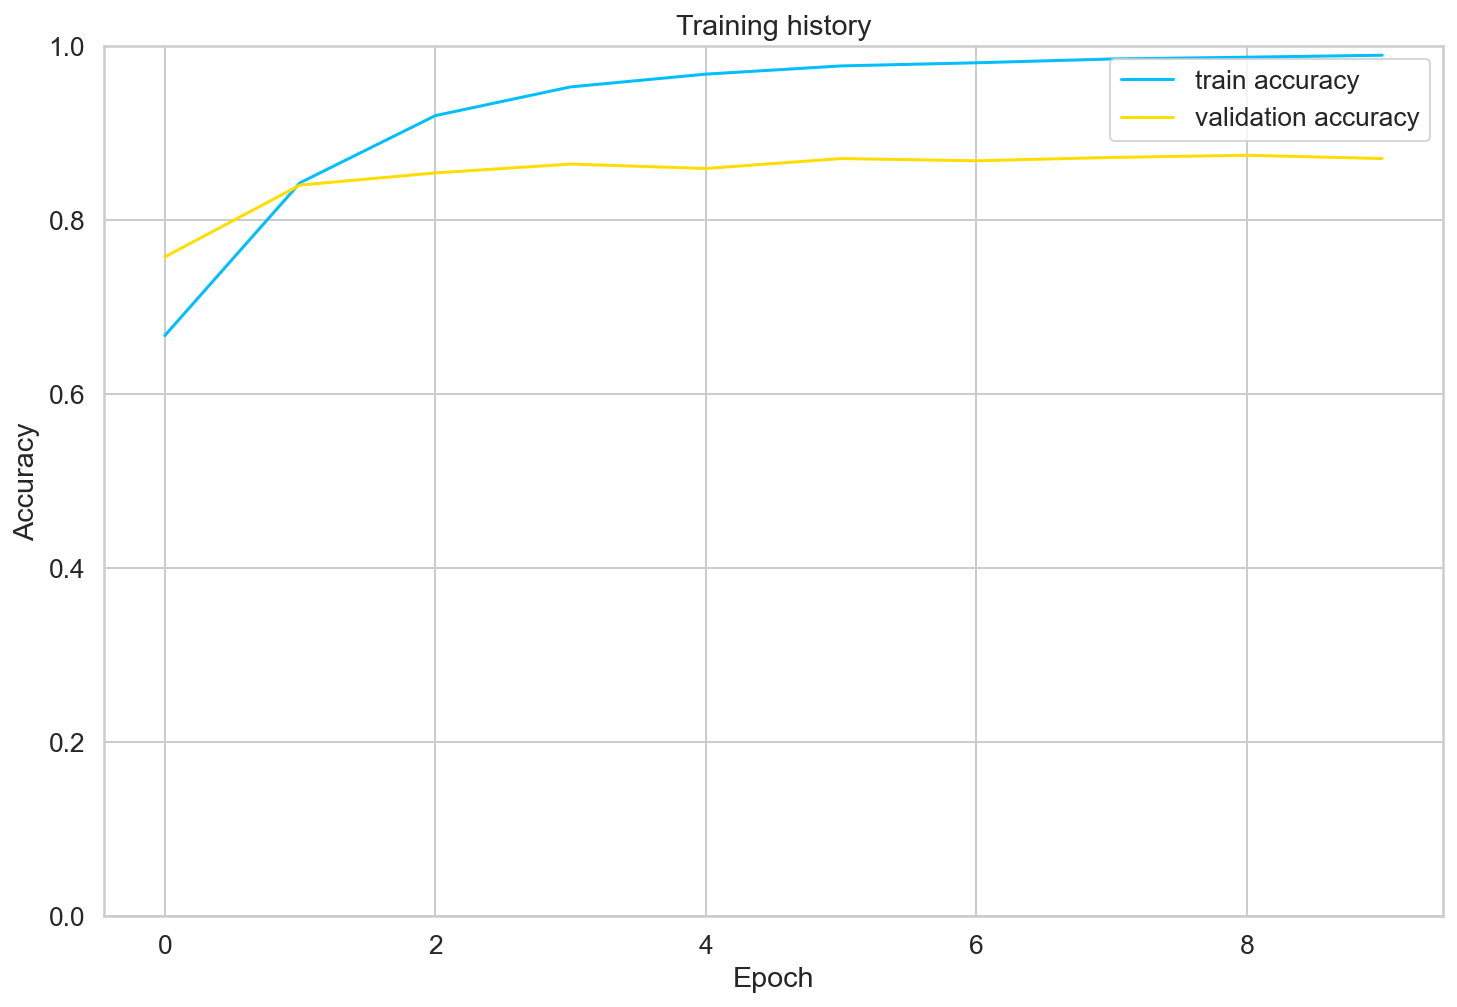

In [54]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Predicting Raw Text

In [48]:
# open text file from nyt api extraction preformed in r 
urls = open("urls.txt", "r")

In [49]:
# extract urls from urls.txt:


# select rows containing urls
temp_lst = []
for item in urls:
    if item[0] == 'R':
        temp_lst.append(item)

# chop off extra string in front of url
temp_lst_2 = []
for item in temp_lst:
    item = item.replace('Response [', '')
    temp_lst_2.append(item)

# chop off extra string at end of url
urls = []
for item in temp_lst_2:
    item = item.replace(']\n', '')
    urls.append(item)

#remove unnsed lists from memory
temp_lst = None
temp_lst_2 = None


In [68]:
#open urls, extract the title of the article, and store it for sentiment analysis
#takes around 20 mins because of sleep(6.0)

#empty title list
title_lst = []

for item in urls:
    #open url
    url = urllib.request.urlopen(item)
    
    #read it
    title_temp = json.loads(url.read().decode())
    
    #subset it, to article title level
    title_temp = title_temp['response']
    title_temp = title_temp['docs']
    
    #final subset and append to title_lst
    for i in title_temp:
        title_lst.append(i['abstract'])
        
    #wait 6 seconds because nyt api restrictions
    sleep(6.0)

In [75]:
# pass each nyt title through sentiment model
review_text_lst = []
prediction_lst = []

for item in title_lst:
    encoded_review = tokenizer.encode_plus(item, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt',)
    
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    
    review_text_lst.append(item)
    prediction_lst.append(class_names[prediction])
    
    

In [77]:
#count up your glorious sentiment results
pos_count = 0
neg_count = 0
neu_count = 0

for item in prediction_lst:
    if item == 'positive':
        pos_count += 1
    elif item == 'neutral':
        neu_count += 1
    else:
        neg_count += 1

In [79]:
print('Positive articles: ', pos_count)
print('Negative articles: ', neg_count)
print('Neutral articles: ', neu_count)

Positive articles:  400
Negative articles:  1148
Neutral articles:  422


Positive articles:  400

Negative articles:  1148

Neutral articles:  422